In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx

%matplotlib inline

In [23]:
from rdkit import Chem

In [24]:
all_res = glob("out/**/*.pkl")

In [25]:
res = load_pickle(all_res[0])

In [26]:
from collections import defaultdict

In [27]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [28]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:

        metrics = {
            "noise_level": res["noise_level"],
            "temp": temp_res["temperature"],
            "frac_valid": temp_res["frac_valid"],
            "frac_unique": temp_res["frac_unique"],
            "frac_smiles_in_train": temp_res["frac_smiles_in_train"],
            "frac_smiles_in_pubchem": temp_res["frac_smiles_in_pubchem"],
            "kld": temp_res["kld"],
            "frechet_d": temp_res["frechet_d"],
            "frechet_score": temp_res["frechet_score"],
            "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
            / len(temp_res["valid_smiles"]),
        }

        generated_smiles.update([s for s in temp_res["generated_smiles"] if is_valid(s)])
        v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

        v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
        generated_smiles_at_temp[temp_res["temperature"]].update(v)

        for me, v in temp_res["e_pi_pi_star_metrics"].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res["z_pi_pi_star_metrics"].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [29]:
contains_azo(list(generated_smiles)[5])

True

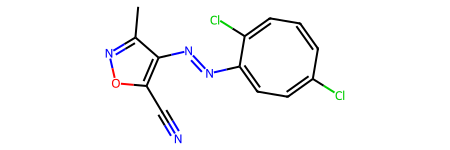

In [30]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [31]:
df = pd.DataFrame(compiled_res)

In [32]:
grouped = df.groupby(["temp"]).agg(["mean", "std"])

In [33]:
grouped

noise_level            frac_valid           frac_unique            \
            mean        std       mean       std        mean       std   
temp                                                                     
0.00       8.125  14.140022   0.989583  0.038259    0.037438  0.020466   
0.10       8.125  14.140022   0.980525  0.036402    0.065131  0.031472   
0.20       8.125  14.140022   0.975996  0.034815    0.125920  0.035278   
0.50       8.125  14.140022   0.971014  0.017161    0.379300  0.041106   
0.75       8.125  14.140022   0.902627  0.033384    0.570800  0.041575   
1.00       8.125  14.140022   0.697917  0.046996    0.769138  0.051791   
1.25       8.125  14.140022   0.326540  0.045946    0.908802  0.068109   
1.50       8.125  14.140022   0.120924  0.033204    1.000000  0.000000   
2.00       8.125  14.140022   0.125453  0.034220    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem            ...  \
                     mean  std                   mean       std  ...   
temp                                                             ...   
0.00                  0.0  0.0               1.000000  0.000000  ...   
0.10                  0.0  0.0               1.000000  0.000000  ...   
0.20                  0.0  0.0               1.000000  0.000000  ...   
0.50                  0.0  0.0               1.000000  0.000000  ...   
0.75                  0.0  0.0               1.000000  0.000000  ...   
1.00                  0.0  0.0               1.000000  0.000000  ...   
1.25                  0.0  0.0               1.000000  0.000000  ...   
1.50                  0.0  0.0               1.000000  0.000000  ...   
2.00                  0.0  0.0               0.986378  0.039665  ...   

     z_pi_pi_star_r2           z_pi_pi_star_max_error             \
                mean       std                   mean        std   
temp                                                               
0.00       -0.043191  0.054393              61.572254  25.712118   
0.10       -0.039987  0.049132              61.989934  26.578796   
0.20       -0.066827  0.061689              62.984851  25.391623   
0.50       -0.147436  0.100029              70.533794  26.939743   
0.75       -0.219255  0.169558              73.256070  25.385352   
1.00       -0.316465  0.217507              70.189462  20.106939   
1.25       -0.507095  0.376553              58.402621  18.043703   
1.50       -3.219800  4.414660              62.712580  26.779688   
2.00       -4.328768  3.292434              68.292860  18.265637   

     z_pi_pi_star_mean_absolute_error             \
                                 mean        std   
temp                                               
0.00                        17.091112   8.335583   
0.10                        17.169255   8.206404   
0.20                        17.470335   8.587455   
0.50                        17.813284   8.253109   
0.75                        17.932351   8.379968   
1.00                        18.695796   7.813233   
1.25                        18.608751   6.625421   
1.50                        29.134478  12.451171   
2.00                        34.175368   4.604907   

     z_pi_pi_star_mean_squared_error              z_pi_pi_star_rmse             
                                mean          std              mean        std  
temp                                                                            
0.00                      615.722086   741.226387         22.680350  10.282470  
0.10                      617.713286   742.200626         22.747966  10.227499  
0.20                      637.252991   767.741894         23.052686  10.508464  
0.50                      663.387616   754.601453         23.753050  10.173123  
0.75                      691.293719   817.763582         24.181111  10.545187  
1.00                      711.597706   686.524547         25.016391   9.460832  
1.25                      650.678135   556.859813         24.252311   8.075958  

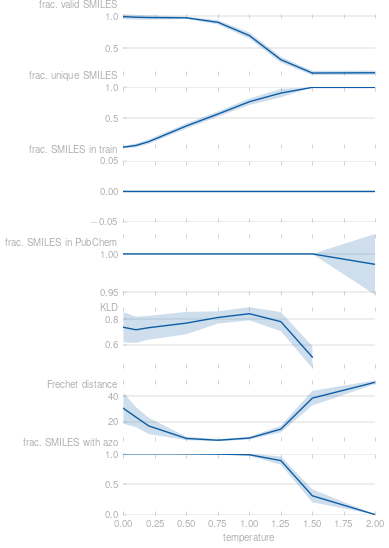

In [34]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
    ax[0].fill_between(
        grouped.index,
        grouped["frac_valid"]["mean"] - grouped["frac_valid"]["std"],
        grouped["frac_valid"]["mean"] + grouped["frac_valid"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. valid SMILES", ax=ax[0])

    ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
    ax[1].fill_between(
        grouped.index,
        grouped["frac_unique"]["mean"] - grouped["frac_unique"]["std"],
        grouped["frac_unique"]["mean"] + grouped["frac_unique"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. unique SMILES", ax=ax[1])

    ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
    ax[2].fill_between(
        grouped.index,
        grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["std"],
        grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in train", ax=ax[2])

    ax[3].plot(
        grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
    )
    ax[3].fill_between(
        grouped.index,
        grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["std"],
        grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in PubChem", ax=ax[3])

    ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
    ax[4].fill_between(
        grouped.index,
        grouped["kld"]["mean"] - grouped["kld"]["std"],
        grouped["kld"]["mean"] + grouped["kld"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("KLD", ax=ax[4])

    ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
    ax[5].fill_between(
        grouped.index,
        grouped["frechet_d"]["mean"] - grouped["frechet_d"]["std"],
        grouped["frechet_d"]["mean"] + grouped["frechet_d"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Frechet distance", ax=ax[5])

    ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
    ax[6].fill_between(
        grouped.index,
        grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["std"],
        grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES with azo", ax=ax[6])

    ax[-1].set_xlabel("temperature", labelpad=4)

    fig.savefig("photoswitch_random_smiles_metrics.pdf", bbox_inches="tight")

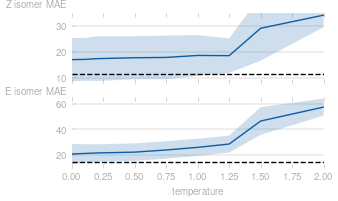

In [35]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        2, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
    )

    ax[0].plot(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[0].fill_between(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Z isomer MAE", ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")

    ax[0].set_ylim(8, 35)

    ax[1].plot(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[1].fill_between(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("E isomer MAE", ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")

    ax[-1].set_xlabel("temperature", labelpad=4)
    ax[1].set_ylim(10, 65)
fig.savefig("random_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [36]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [37]:
import os
import shutil

In [38]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [39]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 406/406 [00:02<00:00, 161.41it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 406/406 [00:02<00:00, 161.24it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 410/410 [00:02<00:00, 163.33it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 469/469 [00:02<00:00, 168.31it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 608/608 [00:03<00:00, 171.69it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 796/796 [00:04<00:00, 171.49it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 736/736 [00:04<00:00, 180.66it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 635/635 [00:03<00:00, 204.27it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 678/678 [00:03<00:00, 217.84it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [40]:
make_figure(1.5)

100%|██████████| 635/635 [00:03<00:00, 198.66it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html